# Stochastic Differential Equation (SDEs)

Continous-state dynamical systems lead determinitical Ordinary Differential Equations systems (ODEs). Stochastic versions of this model are Stochastic Differential Equations (SDEs).

## Fitzhugh Nagumo Model
    

\begin{equation}
\begin{split}
\frac{dv}{dt} =&  v-v^3-w+I_{ext}\\
\frac{dw}{dt} =& \frac{1}{\tau}(v-a-bw)
\end{split}
\end{equation}

In [20]:
import numpy as np
import pandas as pd
from functools import partial
from scipy.integrate import odeint

def fitzhugh_nagumo(x, t, a, b, tau, I):
    """
        Fitzhugh-Nagumo model.
    """
    v, w = x
    
    dvdt = v-v**3-w+I
    dwdt = (v-a-b*w)/tau
    
    return np.array([dvdt, dwdt])

def plot_vector_field(ax, model, param, xrange, yrange, steps=50):
    # Compute the vector field
    x = np.linspace(xrange[0], xrange[1], steps)
    y = np.linspace(yrange[0], yrange[1], steps)
    X,Y = np.meshgrid(x,y)
    
    dx,dy = model([X,Y],0, **param)   
    
    # streamplot is an alternative to quiver 
    # that looks nicer when your vector filed is
    # continuous.
    ax.streamplot(X,Y,dx, dy, color=(0,0,0,.1))
    
    ax.set(xlim=(xrange[0], xrange[1]), ylim=(yrange[0], yrange[1]))

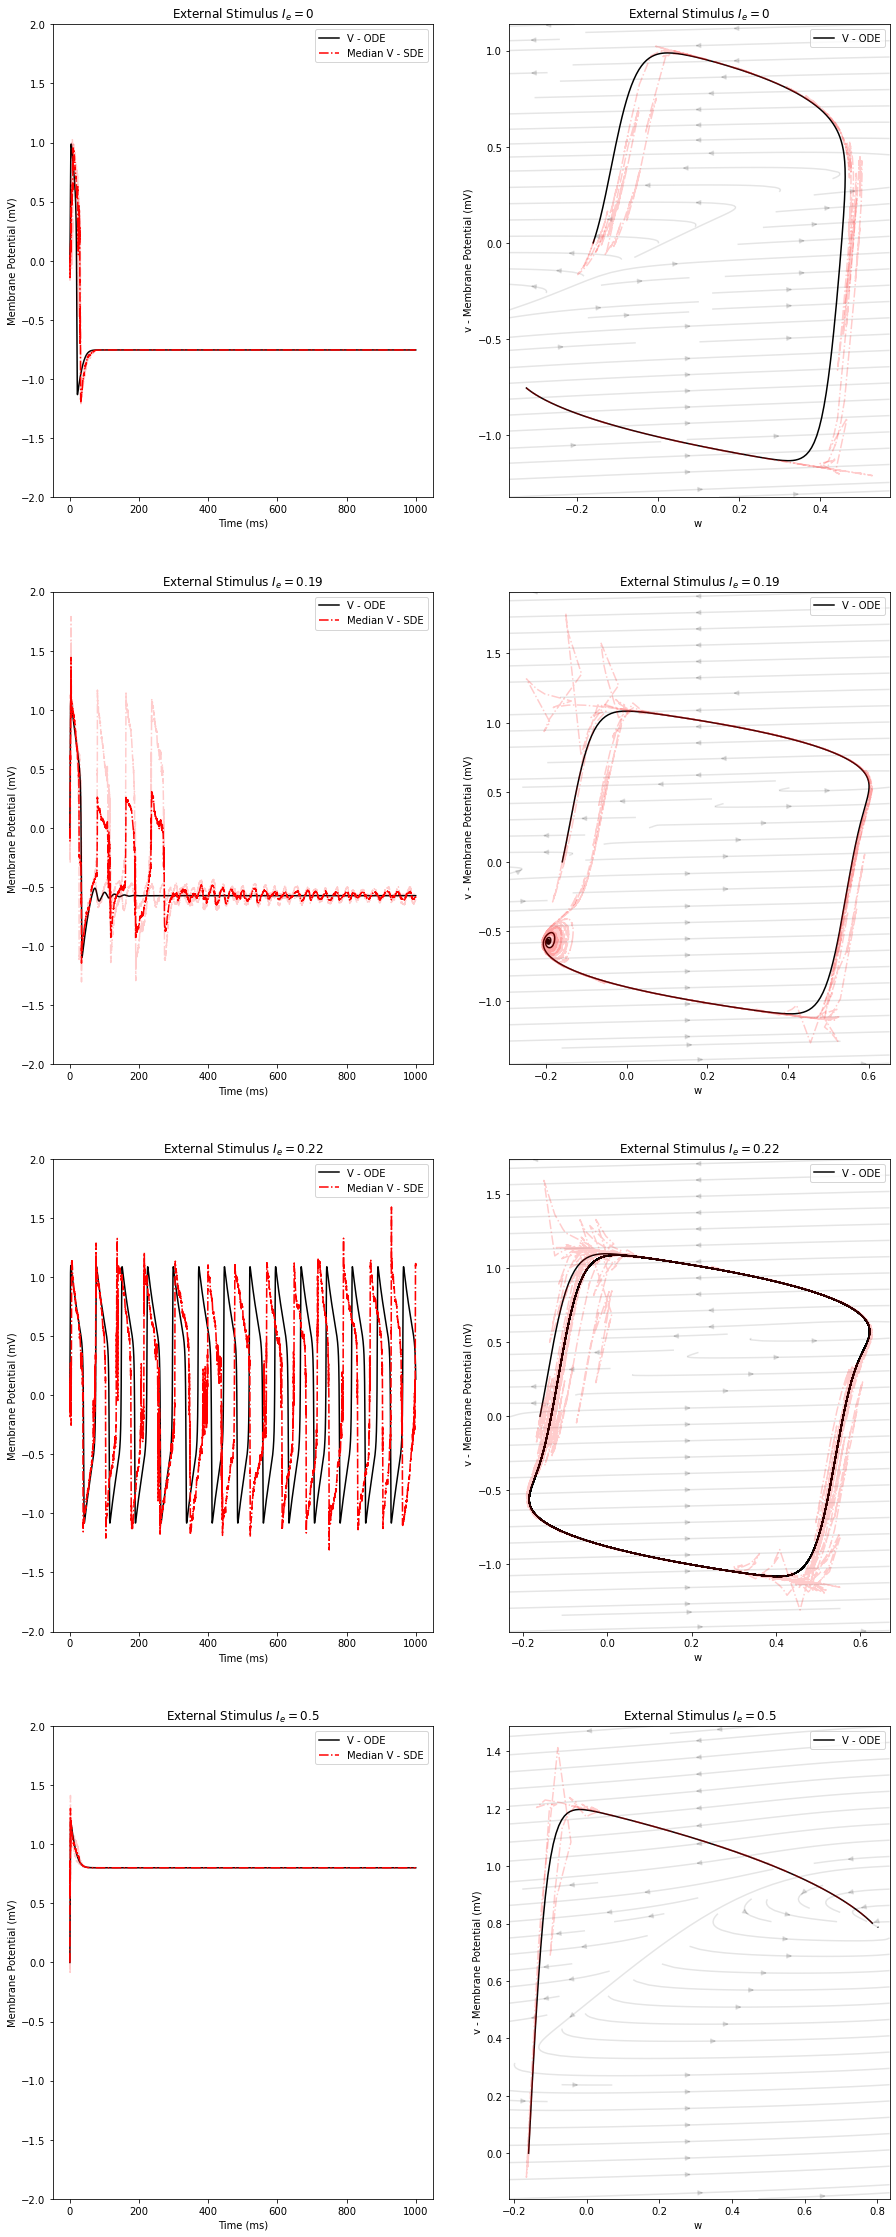

In [29]:
xlimit = (-1.3, 1.3)
ylimit = (-0.5, 0.5)

def integration_SDE(model, noise_flow, y0, t) :
    ''' Euler integration.
        y(t) = f(Y(t),t)dt + g(Yt,t)dBt
        y(0) = y0 
    '''
    y = np.zeros((len(t),len(y0)))
    y[0] = y0
    
    for n, dt in enumerate(np.diff(t),1):
        y[n] = y[n-1] + model(y[n-1],dt) * dt + model(y[n-1],dt) * np.random.normal(0,np.sqrt(dt))
    
    return y

n_runs = 2
t_span = np.linspace(0, 1000, num=10000)
brownian_noise = lambda y,t: 0.04


initial_conditions = [(-0.5,-0.1), [0, -0.16016209760708508]]

I_ext = [0, 0.19, 0.22, 0.5]


import matplotlib.pyplot as plt
fig, ax = plt.subplots(len(I_ext), 2, figsize=(15, 10*len(I_ext)))

for idx, current_ext in enumerate(I_ext):
    # Evaluate fitzhugh_nagumo model with specified pameters a, b, tau, I in param
    param = {'a': -0.3, 'b':1.4, 'tau':20, 'I':current_ext}
    
    model = partial(fitzhugh_nagumo, **param)
    ic = initial_conditions[1]

    sde_solutions = np.zeros((10000,2,n_runs))
    for i in range(n_runs):
        sde_solutions[:,:,i] = integration_SDE(model,
                                      brownian_noise,
                                      y0=ic,
                                      t=t_span)

    ode_solution = odeint(model, y0=ic, t=t_span)

    v_sde, w_sde = (sde_solutions[:,0,:], sde_solutions[:,1,:])

    # Drop nans in case stochastic run results in ill solution
    v_sde = pd.DataFrame(v_sde).dropna(axis=1).to_numpy()
    
    # Drop nans in case stochastic run results in ill solution
    w_sde = pd.DataFrame(w_sde).dropna(axis=1).to_numpy()

    v_ode, w_ode = (ode_solution[:,0], ode_solution[:,1])


    ax[idx,0].plot(t_span, v_ode, label='V - ODE', color='k')
    ax[idx,0].plot(t_span, np.median(v_sde, 1), label=r'Median V - SDE', color='r', linestyle='-.')
    ax[idx,0].plot(t_span, v_sde, color='r', linestyle='-.', alpha=0.2)
    ax[idx,0].set_xlabel('Time (ms)')
    ax[idx,0].set_ylabel('Membrane Potential (mV)')
    ax[idx,0].set_title(r'External Stimulus $I_e=${}'.format(param['I']))
    ax[idx,0].set_ylim([-2,2])
    ax[idx,0].legend()

    ax[idx,1].plot(w_ode, v_ode, label='V - ODE', color='k')
    #ax[idx,1].plot(np.median(w_sde, 1), np.median(v_sde, 1), label=r'Median V - SDE', color='r', linestyle='-.')
    ax[idx,1].plot(w_sde, v_sde, color='r', linestyle='-.', alpha=0.2)
    ax[idx,1].set_xlabel('w ')
    ax[idx,1].set_ylabel(' v - Membrane Potential (mV)')
    ax[idx,1].set_title(r'External Stimulus $I_e=${}'.format(param['I']))
    ylims = ax[idx,1].get_ylim()
    ax[idx,1].legend()
    xlims = ax[idx,1].get_xlim()
    plot_vector_field(ax[idx,1], fitzhugh_nagumo, param, xlims, ylims, steps=100)

